## Classifying Good Product Reviews: Baseline Model

**Team J Cubed**: James Wei, Jessica Ko, Jay Patel

CS 294-129, Fall 2016

### Organize imports

In [1]:
from __future__ import division, print_function, absolute_import
from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
import sklearn
import string

### Load and split dataset

Note that the 'review_text' field in the dataset has already been normalized (removed capitalization, punctuation, and stopwords).

In [2]:
def split_train_test(df, test_size):
    train, test = train_test_split(df, test_size=test_size, random_state=random.randint(0, 99))
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    return train, test

dataset_path = 'data/supermin_good_20k_fullcols.csv' # Minimized dataset

df = pd.read_csv(dataset_path, sep='|', index_col=0)

# Training: 60%, Validation: 20%, Testing: 20%
df_train, df_test = split_train_test(df, 0.200)
df_train, df_val = split_train_test(df_train, 0.250)

df_train.head()

,reviewer_id,asin,review_text,overall,category,good,bad
0,A1DE6GXMW2FMAJ,B003PFGSVW,serious percussion someone small size absolute...,5.0,12,1,0
1,AHV1ZKIVZKBUC,6302533953,soso liked flim realistic excellent plot actin...,3.0,15,0,1
2,A3GSPI69JGM5W9,0465013058,depth analysis state scientific awareness unsc...,4.0,5,0,0
3,A26S6MNOJ27EBE,080652071X,help bos pretty new craft almost years wicca b...,4.0,5,1,0
4,AGL4RFFH4UZBH,1477808620,author research correctly roanoak virginia mid...,1.0,5,0,0


### Featurize

#### tf-idf

In [3]:
class TfidfFeaturizer(object):
    def __init__(self, col_name='review_text', max_features=1000):
        self.col_name = col_name
        self.max_features = max_features
        self.vectorizer = None
        
    def fit_transform(self, df):
        docs = self.__create_doc_list(df)
        self.vectorizer = TfidfVectorizer(
            ngram_range=(1,3),
            max_features=self.max_features
        )
        return (self.vectorizer.fit_transform(docs)).toarray()

    def transform(self, df):
        if self.vectorizer is not None:
            docs = self.__create_doc_list(df)
            return (self.vectorizer.transform(docs)).toarray()
        else:
            return None

    def __create_doc_list(self, df):
        return df[self.col_name].tolist()

n_tfidf_features = 300
tfidf_featurizer = TfidfFeaturizer(max_features=n_tfidf_features)

print('Fitting tf-idf featurizer.')
tfidf_featurizer.fit_transform(df)

print('Featurizing training set.')
tfidf_train = tfidf_featurizer.transform(df_train)
n_train = tfidf_train.shape[0]
print('Shape:', tfidf_train.shape)

print('Featurizing validation set.')
tfidf_val = tfidf_featurizer.transform(df_val)
n_val = tfidf_val.shape[0]
print('Shape:', tfidf_val.shape)

print('Featurizing test set.')
tfidf_test = tfidf_featurizer.transform(df_test)
n_test = tfidf_test.shape[0]
print('Shape:', tfidf_test.shape)

Fitting tf-idf featurizer.
Featurizing training set.
Shape: (12000, 300)
Featurizing validation set.
Shape: (4000, 300)
Featurizing test set.
Shape: (4000, 300)


In [4]:
matrix_train = tfidf_train
matrix_val   = tfidf_val
matrix_test  = tfidf_test

### Configure labels

In [5]:
target_class = 'good'

labels_train = np.array(df_train[target_class])
labels_val = np.array(df_val[target_class])
labels_test = np.array(df_test[target_class])

### Tune logistic regression

In [6]:
def make_rand_range(start, end, n):
    rr = []
    for _ in xrange(n):
        rr.append(start + (abs(end - start) * random.random()))
    return sorted(rr)

reg_str = [0.01, 0.1, 1.0, 10, 100]
best_val_acc = -1.0
best_c = None

for c in reg_str:
    lr = LogisticRegression(penalty='l2', C=c, n_jobs=-1)
    lr.fit(matrix_train, labels_train)
    preds = lr.predict(matrix_val)
    acc = np.mean(preds == labels_val)
    print('regularization strength:', c, '|', 'validation set accuracy:', acc)
    if acc > best_val_acc:
        best_val_acc = acc
        best_c = c

regularization strength: 0.01 | validation set accuracy: 0.742
regularization strength: 0.1 | validation set accuracy: 0.74875
regularization strength: 1.0 | validation set accuracy: 0.7445
regularization strength: 10 | validation set accuracy: 0.74375
regularization strength: 100 | validation set accuracy: 0.743


In [7]:
reg_str = make_rand_range(0, 10, 300)

for t, c in enumerate(reg_str):
    should_print = False
    lr = LogisticRegression(penalty='l2', C=c, n_jobs=-1)
    lr.fit(matrix_train, labels_train)
    preds = lr.predict(matrix_val)
    acc = np.mean(preds == labels_val)
    if acc > best_val_acc:
        best_val_acc = acc
        best_c = c
        should_print = True
    if t % 15 == 0 or should_print:
        print('regularization strength:', c, '|', 'validation set accuracy:', acc)

regularization strength: 0.072869363562 | validation set accuracy: 0.747
regularization strength: 0.539835407523 | validation set accuracy: 0.74425
regularization strength: 0.884800639629 | validation set accuracy: 0.74475
regularization strength: 1.48705486427 | validation set accuracy: 0.74525
regularization strength: 2.00649235665 | validation set accuracy: 0.7455
regularization strength: 2.49710496361 | validation set accuracy: 0.74525
regularization strength: 2.95091452827 | validation set accuracy: 0.74475
regularization strength: 3.35722783204 | validation set accuracy: 0.745
regularization strength: 3.82624225151 | validation set accuracy: 0.74425
regularization strength: 4.23276817618 | validation set accuracy: 0.74425
regularization strength: 4.68589394028 | validation set accuracy: 0.74375
regularization strength: 5.25125324932 | validation set accuracy: 0.7435
regularization strength: 5.69695686877 | validation set accuracy: 0.744
regularization strength: 6.10704810328 | va

### Evaluate model on test set

In [8]:
matrix_train_val = np.vstack([matrix_train, matrix_val])
labels_train_val = np.hstack([labels_train, labels_val])

lr = LogisticRegression(penalty='l2', C=best_c, n_jobs=-1)
lr.fit(matrix_train_val, labels_train_val)
preds_test = lr.predict(matrix_test)
acc_test = np.mean(preds_test == labels_test)

print('final test set accuracy:', acc_test)

final test set accuracy: 0.74075


### Visualize results

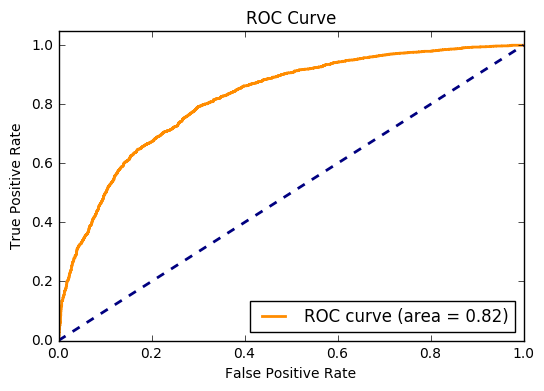

In [9]:
preds_probs = lr.predict_proba(matrix_test)

fpr, tpr, _ = roc_curve(labels_test, preds_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()